## Flashbots + Dune Mempool Analytics

This notebook leverages Flashbots [public mempool datasets](https://mempool-dumpster.flashbots.net/index.html), combining the data wit block data from [Dune Analytics](https://dune.com/) to cluster transactions between private mempool, public mempool, and not-included transactions.

- The Flashbots data comes in parquet files.
- This notebook uses CSVs from Dune Analytics because the dataset would cost thousands of credits to download through the API.
  - https://dune.com/queries/3000017
- This notebook also uses a CSV from Dune Analytics for tracking sandwich trades, although this might make sense to do via the API.
  - https://dune.com/queries/3000675

**\
This script assumes that all the data files have been renamed in the convention of: YYYY-MM-DD-dune-transactions.csv, YYYY-MM-DD-sandwich-tx.csv, YYYY-MM-DD.parquet\
**

---

- Author: [Data Always](dataalways.substack.com)
- Last Modified: September 7, 2023

TODO: fix the sandwich data Dune query to output frontrun and backrun hashes in the same column.
- Currently the csv download requires post-processing to turn the two columns into one and rename the column 'hash'

In [1]:
""" The date of the data that you have downloaded. """
date_str = '2023-08-08'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
"""
- Read in the flashbots data and drop all of the unnecessary columns. 
- We want to use Dune as our source of truth, so we only want the 
  timestamp and the transaction hash to merge into the Dune data.
"""

df_mempool = pd.read_parquet(f'./datasets/{date_str}.parquet')
df_mempool.drop(
    columns=[
        'chainId', 
        'from', 
        'to', 
        'value', 
        'gasPrice', 
        'gasTipCap', 
        'gasFeeCap', 
        'dataSize', 
        'data4Bytes',
    ], 
    inplace=True,
)
#df_mempool.tail()

In [4]:
"""
Read in the Dune data and calculate the extra columns we want.
"""

df_dune = pd.read_csv(f'./datasets/{date_str}-dune-transactions.csv')
df_dune['base_fees'] = df_dune['gas_used'] * df_dune['base_fee_per_gas'] * 1e-18
df_dune['priority_fees'] = df_dune['gas_used'] * (df_dune['gas_price'] - df_dune['base_fee_per_gas']) * 1e-18
#df_dune.head()

In [5]:
"""
Now we merge the two datasets together on the hash, and calculate
the difference between the detection time and the block time to 
get the inclusion time. 
"""

# TODO: rename away from xx. 
public_mempool = pd.merge(df_dune, df_mempool, how='inner', on = 'hash')
public_mempool['inclusion_delay'] = pd.to_datetime(public_mempool['block_time']).dt.tz_localize(None) - public_mempool['timestamp']

# TODO: verify that this does something, doesn't need to be inplace?
#xx.reset_index(drop=True)
#xx.tail()

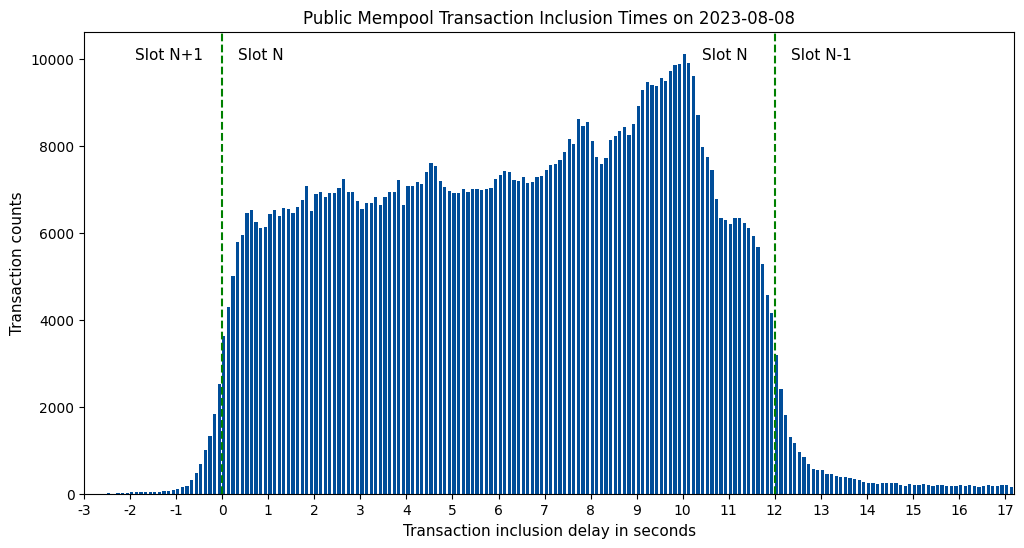

In [21]:
"""
Plot the inclusion time profile.
"""

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title(f'Public Mempool Transaction Inclusion Times on {date_str}')
ax1.set_xlabel('Transaction inclusion delay in seconds', fontsize=11)
ax1.set_ylabel('Transaction counts', fontsize=11)

""" Setup bins for the histogram and plot it."""
bin_size = 0.1
bins = np.arange(-5, 45, bin_size)
plt.hist(public_mempool['inclusion_delay'].dt.total_seconds(), bins=bins, width=0.7*bin_size, color=[0, 0.3, 0.6], alpha=1, zorder = 1.6) #b

""" Format the x-axis. """
ax1.set_xticks([x for x in np.arange(-5, 25, 1)])
ax1.set_xlim([-3, 17.2])
ax1.set_xticklabels([x for x in np.arange(-5, 25, 1)])


""" Annotations around slot timing. """
ax1.axvline(x = 0, color = 'g', lw=1.5, ls='--')
ax1.axvline(x = 12, color = 'g', lw=1.5, ls='--')
ax1.annotate('Slot N+1', xy=(-0.42, ax1.get_ylim()[1]*0.95), xycoords='data', va='center', ha='right', size=11)
ax1.annotate('Slot N',   xy=(0.35,  ax1.get_ylim()[1]*0.95), xycoords='data', va='center', ha='left',  size=11)
ax1.annotate('Slot N',   xy=(11.42, ax1.get_ylim()[1]*0.95), xycoords='data', va='center', ha='right', size=11)
ax1.annotate('Slot N-1', xy=(12.35, ax1.get_ylim()[1]*0.95), xycoords='data', va='center', ha='left',  size=11)

"""
plt.savefig(
    f'./tmp-figures/tx-profile.png', 
    transparent=False, 
    facecolor=ax1.get_facecolor(), 
    dpi = 150
)
"""
plt.show()

In [22]:
"""
Read in the sandwich transaction data and merge it into the transaction data
to get the other statistics that we want.
"""

df_sandwich = pd.read_csv(f'./datasets/{date_str}-sandwich-tx.csv')
sandwich_stats = pd.merge(
    df_dune, 
    df_sandwich, 
    how='inner', 
    on = 'hash'
)

# Warn the user if there are any missing transactions.
assert(len(sandwich_stats) == len(df_sandwich))
#sandwich_stats.tail()

In [23]:
""" 
Define common pie chart attributes
"""

""" Handle the colors"""
c1 = [0.3, 0.1, 0.1]
c2 = [0.4, 0.4, 0]
c3 = [0.3, 0.5, 0.5]
colors = [c1, c2, c3]

""" Handle paramaters"""
wedgesettings = {"linewidth": 0}
textsettings = {"fontsize":11, "color":[1]*3}
labels = ['Sandwich (Private)', 'Private Mempool', 'Public Mempool']

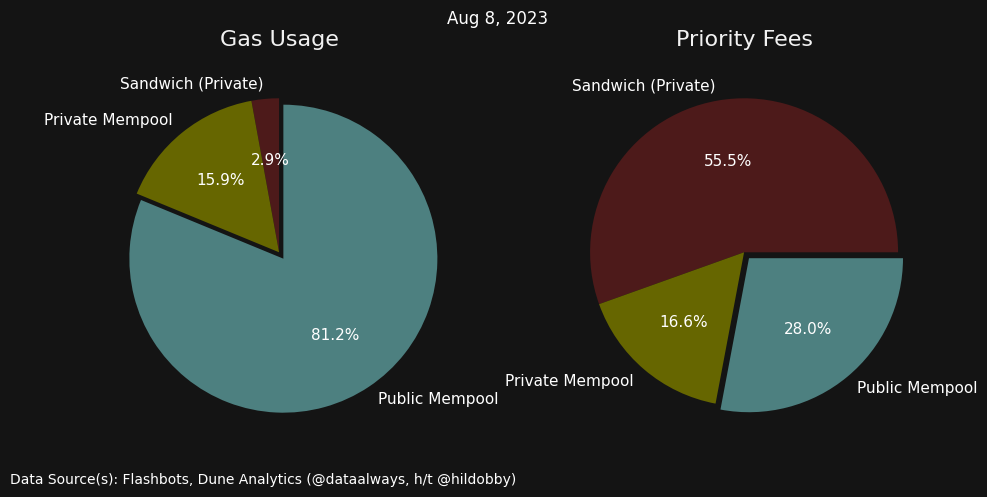

In [30]:
fig, ax1 = plt.subplots(1,2, figsize=(11, 5))
plt.suptitle('Aug 8, 2023', color = 'w')

off_black = [0.08]*3
fig.set_facecolor(off_black) 
ax1[0].set_facecolor(off_black)
ax1[1].set_facecolor(off_black)

""" Plot the gas usage pie chart"""
v1 = sandwich_stats['gas_used'].sum()
v2 = df_dune['gas_used'].sum() - public_mempool['gas_used'].sum() - sandwich_stats['gas_used'].sum()
v3 = public_mempool['gas_used'].sum()

ax1[0].pie(
    [v1, v2, v3],
    labels = labels,
    colors = colors, 
    autopct = "%0.1f%%",
    explode = (0, 0, 0.05), 
    shadow = False,
    wedgeprops = wedgesettings,
    textprops = textsettings,
    radius = 1,
    startangle = 90
)

""" Plot the priority fee pie chart"""
w1 = sandwich_stats['priority_fees'].sum()
w2 = df_dune['priority_fees'].sum() - public_mempool['priority_fees'].sum() - sandwich_stats['priority_fees'].sum()
w3 = public_mempool['priority_fees'].sum()

ax1[1].pie(
    [w1, w2, w3],
    labels = labels,
    colors = colors, 
    autopct = "%0.1f%%",
    explode = (0, 0, 0.05), 
    shadow = False,
    wedgeprops = wedgesettings,
    textprops = textsettings,
    radius = 1
)

ax1[0].set_title('Gas Usage', fontsize=16, pad=10, color=[0.95]*3)
ax1[1].set_title('Priority Fees', fontsize=16, pad=10, color=[0.95]*3)

plt.annotate(
    f'Data Source(s): Flashbots, Dune Analytics (@dataalways, h/t @hildobby)', 
    xy=(-1.45, -0.03), 
    xytext=(12, -12), 
    va='top', 
    ha='left',
    xycoords='axes fraction', 
    textcoords='offset points', 
    size=10,
    color = 'w'
)


"""
plt.savefig(
    f'./tmp-figures/pie-example.png', 
    transparent=False, 
    dpi = 150, 
    facecolor=off_black
)
"""
plt.show()